# Summarize Results of Model Training
Find the best model for each porblem

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from pathlib import Path
import pandas as pd
import json

Configuration

In [2]:
prop, level = 'oxidation_potential', 'mopac_pm7-acn-adiabatic'

## Load all records
The last thing our training script does is write `params.json`. Find these files then load in the assoicated data

In [3]:
run_paths = list(Path('./lightning_logs/').glob('**/params.json'))
print(f'Found {len(run_paths)} runs')

Found 11 runs


Make the load function

In [4]:
def load_run(param_path: Path) -> dict:
    """Load in data about a run
    
    Args:
        param_path: Path to the parameter file
    Returns:
        Summary of the run
    """
    
    # Load the parameters
    params = json.loads(param_path.read_text())
    params['run_path'] = param_path.parent
    
    # Flatten
    for k, v in params['model_kwargs'].items():
        params[f'hp.{k}'] = v
    params['model_kwargs']
    
    # Load the performance
    test_data = pd.read_csv(param_path.parent / 'predictions.csv.gz')
    params['mae'] = mean_absolute_error(test_data['true'], test_data['pred'])
    params['r2'] = r2_score(test_data['true'], test_data['pred'])
    return params

In [5]:
runs = pd.DataFrame([load_run(r) for r in run_paths]).sort_values('mae')
runs

,seed,data_path,learning_rate,weight_decay,model_kwargs,num_loaders,batch_size,model,epochs,fast_runs,target_property,target_method,run_path,hp.hidden_dim,hp.num_conv,mae,r2
2,12156906,../datasets/mdf-mos,0.0005,0.0,"{'hidden_dim': 256, 'num_conv': 6}",4,64,EGNN,32,None,oxidation_potential,xtb-vertical,lightning_logs/version_4,256,6.0,0.078455,0.924612
8,12156906,../datasets/mdf-mos,0.0005,0.0,"{'hidden_dim': 256, 'num_conv': 6}",4,64,EGNN,32,None,oxidation_potential,xtb-vertical,lightning_logs/version_5,256,6.0,0.082232,0.918855
5,12156906,../datasets/mdf-mos,0.0005,0.0,"{'hidden_dim': 128, 'num_conv': 6}",4,64,EGNN,32,None,oxidation_potential,xtb-vertical,lightning_logs/version_3,128,6.0,0.083626,0.917218
9,12156906,../datasets/mdf-mos,0.0005,0.0,{'hidden_dim': 128},4,64,EGNN,32,None,oxidation_potential,xtb-vertical,lightning_logs/version_2,128,NaN,0.086950,0.909957
7,12156906,../datasets/mdf-mos,0.0005,0.0,{'hidden_dim': 128},4,64,EGNN,16,None,oxidation_potential,xtb-vertical,lightning_logs/version_1,128,NaN,0.090044,0.902878
6,12156906,../datasets/mdf-mos,0.0005,0.0,{'hidden_dim': 128},4,64,EGNN,2,None,oxidation_potential,xtb-vertical,lightning_logs/version_0,128,NaN,0.116202,0.843920
3,12156906,../datasets/mdf-mos,0.0005,0.0,"{'hidden_dim': 256, 'num_conv': 6}",4,64,EGNN,128,None,oxidation_potential,mopac_pm7-acn-adiabatic,lightning_logs/version_7,256,6.0,0.204383,0.575210
4,12156906,../datasets/mdf-mos,0.0005,0.0,"{'hidden_dim': 256, 'num_conv': 6}",4,64,EGNN,32,None,oxidation_potential,mopac_pm7-acn-adiabatic,lightning_logs/version_6,256,6.0,0.213355,0.544973
10,12156906,../datasets/mdf-mos,0.0005,0.0,"{'hidden_dim': 128, 'num_conv': 6}",4,64,EGNN,128,None,oxidation_potential,mopac_pm7-acn-adiabatic,lightning_logs/version_9,128,6.0,0.214270,0.528458
1,12156906,../datasets/mdf-mos,0.0005,0.0,"{'hidden_dim': 128, 'num_conv': 3}",4,64,EGNN,128,None,oxidation_potential,mopac_pm7-acn-adiabatic,lightning_logs/version_8,128,3.0,0.224155,0.488191


## Plot Performance of Best Model
Plot the predicted vs actual and the learning as a function of epoch

In [6]:
best_run = runs.query(f'target_property=="{prop}" and target_method=="{level}"').sort_values('mae').iloc[0]
best_run

seed                                         12156906
data_path                         ../datasets/mdf-mos
learning_rate                                  0.0005
weight_decay                                      0.0
model_kwargs       {'hidden_dim': 256, 'num_conv': 6}
num_loaders                                         4
batch_size                                         64
model                                            EGNN
epochs                                            128
fast_runs                                        None
target_property                   oxidation_potential
target_method                 mopac_pm7-acn-adiabatic
run_path                     lightning_logs/version_7
hp.hidden_dim                                     256
hp.num_conv                                       6.0
mae                                          0.204383
r2                                            0.57521
Name: 3, dtype: object

Loss vs epoch

In [7]:
log_data = pd.read_csv(best_run.run_path / 'metrics.csv')

Text(0, 0.5, 'Loss')

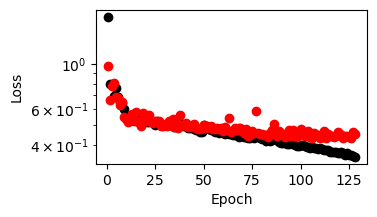

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(log_data['epoch'] + 1, log_data['train_loss_epoch'], 'k--o')
ax.plot(log_data['epoch'] + 1, log_data['val_loss_epoch'], 'r--o')

ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

Predicted vs Actual

In [9]:
test_data = pd.read_csv(best_run.run_path / 'predictions.csv.gz')

Text(0, 0.5, 'Pred (V)')

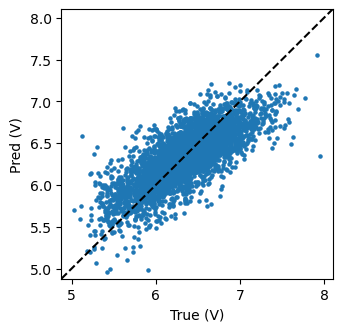

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['true'], test_data['pred'], s=5)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('True (V)')
ax.set_ylabel('Pred (V)')


## Store Best Model for Each Property
Save the type and kwargs for each level

In [11]:
best_dir = Path('best_models')
best_dir.mkdir(exist_ok=True)
for (prop, level), group in runs.groupby(['target_property', 'target_method']):
    (best_dir / f'{prop}-{level}.json').write_text(
        json.dumps(group.drop(columns=['run_path']).sort_values('r2').iloc[-1].to_dict(), indent=2)
    )